In [17]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np

# Load the data from the .npz file
data = np.load('/content/rotated_mnist (1).npz')

# Access the data arrays
rotated_x_train = data['x_train']
rotated_y_train = data['y_train']
rotated_x_test = data['x_test']
rotated_y_test = data['y_test']

# Print the shape of the data arrays to show the data clust
print("Shape of rotated_x_train:", rotated_x_train.shape)
print("Shape of rotated_y_train:", rotated_y_train.shape)
print("Shape of rotated_x_test:", rotated_x_test.shape)
print("Shape of rotated_y_test:", rotated_y_test.shape)


Shape of rotated_x_train: (152400, 28, 28)
Shape of rotated_y_train: (152400,)
Shape of rotated_x_test: (26004, 28, 28)
Shape of rotated_y_test: (26004,)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Load the rotated MNIST dataset
# Assuming 'rotated_mnist.npz' contains 'x_train', 'y_train', 'x_test', 'y_test'
# data = np.load('rotated_mnist.npz')
# rotated_x_train = data['x_train']
# rotated_y_train = data['y_train']
# rotated_x_test = data['x_test']
# rotated_y_test = data['y_test']


rotated_x_train = rotated_x_train.astype("float32") / 255.0
rotated_x_test = rotated_x_test.astype("float32") / 255.0
rotated_x_train = np.expand_dims(rotated_x_train, -1)
rotated_x_test = np.expand_dims(rotated_x_test, -1)


latent_dim = 10  # Adjust as needed

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        #z = self.sampling(z_mean, z_log_var)#added
        reconstruction = self.decoder(z)
        return reconstruction

    def sampling(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(rotated_x_train, epochs=10, batch_size=128)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 14, 14, 32)     │            320 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 7, 7, 64)       │         18,496 │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 3136)           │              0 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 16)             │         50,192 │ flatten_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │            170 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │            170 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,348 (270.89 KB)

 Trainable params: 69,348 (270.89 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3136)                │          34,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_27                  │ (None, 14, 14, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_28                  │ (None, 28, 28, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_29                  │ (None, 28, 28, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,177 (352.25 KB)

 Trainable params: 90,177 (352.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 231s 190ms/step - kl_loss: 6.3946 - loss: 206.7827 - reconstruction_loss: 200.3880
Epoch 2/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 234s 197ms/step - kl_loss: 8.9901 - loss: 136.5442 - reconstruction_loss: 127.5541
Epoch 3/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 231s 194ms/step - kl_loss: 9.0365 - loss: 129.6606 - reconstruction_loss: 120.6241
Epoch 4/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 255s 188ms/step - kl_loss: 9.0318 - loss: 127.6507 - reconstruction_loss: 118.6189
Epoch 5/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 260s 187ms/step - kl_loss: 8.9601 - loss: 126.3701 - reconstruction_loss: 117.4101
Epoch 6/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 225s 189ms/step - kl_loss: 8.9197 - loss: 124.9830 - reconstruction_loss: 116.0634
Epoch 7/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 262s 189ms/step - kl_loss: 8.8734 - loss: 124.8145 - reconstruction_loss: 115.9411
Epoch 8/10
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 225s 189ms/step - kl_loss: 8.8679 - loss: 123.8822 - reconstruction_loss: 115.0143


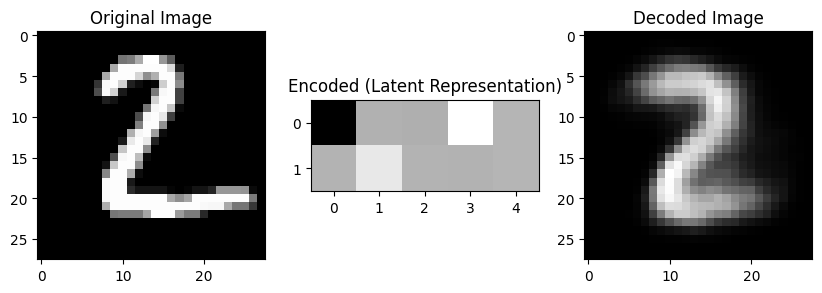

In [ ]:
import matplotlib.pyplot as plt


original_image = rotated_x_test[0]

# Encode the image
z_mean, z_log_var, z = vae.encoder(original_image[None, ...])  # Add batch dimension

# Decode the encoded representation
decoded_image = vae.decoder(z).numpy()

# Display the original, encoded, and decoded images
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_image.squeeze(), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
# Reshape z_mean to a 2D array for visualization
# For example, if latent_dim is 10, you could reshape to (2, 5) or (5, 2)
z_mean_reshaped = z_mean.numpy().reshape(2, 5)  # Adjust reshape dimensions as needed
plt.imshow(z_mean_reshaped, cmap='gray')
plt.title('Encoded (Latent Representation)')

plt.subplot(1, 3, 3)
plt.imshow(decoded_image.squeeze(), cmap='gray')
plt.title('Decoded Image')

plt.show()

In [ ]:
vae.encoder.save_weights("/content/drive/MyDrive/GSOC/GSOC/task2(g)/encoder_weights.weights.h5")
vae.decoder.save_weights("/content/drive/MyDrive/GSOC/GSOC/task2(g)/decoder_weights.weights.h5")

In [ ]:

latent_dim = 10  # Adjust as needed

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        #z = self.sampling(z_mean, z_log_var)#added
        reconstruction = self.decoder(z)
        return reconstruction

    def sampling(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 3136)           │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 16)             │         50,192 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │            170 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │            170 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,348 (270.89 KB)

 Trainable params: 69,348 (270.89 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3136)                │          34,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,177 (352.25 KB)

 Trainable params: 90,177 (352.25 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Loading:
encoder = encoder #Use the original encoder definition.
decoder = decoder #Use the original decoder definition.
vae = VAE(encoder, decoder)

# Load weights:
encoder.load_weights("/content/drive/MyDrive/GSOC/GSOC/task2(g)/encoder_weights.weights.h5")
decoder.load_weights("/content/drive/MyDrive/GSOC/GSOC/task2(g)/decoder_weights.weights.h5")

print("VAE weights loaded, model reconstructed.")

VAE weights loaded, model reconstructed.


#SUPERVISED MLP

In [ ]:

import numpy as np

# Load the data from the .npz file
data = np.load('/content/rotated_mnist (1).npz')

# Access the data arrays
rotated_x_train = data['x_train']
rotated_y_train = data['y_train']
rotated_x_test = data['x_test']
rotated_y_test = data['y_test']

# Print the shape of the data arrays to show the data clust
print("Shape of rotated_x_train:", rotated_x_train.shape)
print("Shape of rotated_y_train:", rotated_y_train.shape)
print("Shape of rotated_x_test:", rotated_x_test.shape)
print("Shape of rotated_y_test:", rotated_y_test.shape)


In [27]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


data = np.load('/content/rotated_mnist (1).npz')
rotated_x_train = data['x_train']
rotated_y_train = data['y_train']
rotated_x_test = data['x_test']
rotated_y_test = data['y_test']



latent_dim = 10
# Set batch size and epochs
batch_size = 64
epochs = 5

# Get latent representations of original and rotated images
z_original = vae.encoder.predict(x_train)[2]  # Assuming x_train is your original training data

# Reshape rotated_x_train to add channel dimension if necessary
rotated_x_train = rotated_x_train.reshape((-1, 28, 28, 1))
#This line is added to reshape rotated_x_train to match the VAE input shape.

# Using only the first 60000 samples of rotated data for training to match z_original
z_rotated_train = vae.encoder.predict(rotated_x_train[:len(x_train)])[2]



# Data Loader Class
class RotatedLatentDataLoader(tf.keras.utils.Sequence):
    def __init__(self, z_original, z_rotated_train, batch_size):
        self.z_original = z_original
        self.z_rotated_train = z_rotated_train
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.z_original) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.z_original[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.z_rotated_train[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

# Create the MLP for supervised symmetry discovery
mlp_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(mlp_inputs)
x = layers.Dense(32, activation='relu')(x)
mlp_outputs = layers.Dense(latent_dim)(x)

mlp = keras.Model(mlp_inputs, mlp_outputs, name='symmetry_mlp')
mlp.summary()

# Create data loader
train_data_loader = RotatedLatentDataLoader(z_original, z_rotated_train, batch_size)

# Train the MLP to map the latent space representation of an image to the latent space representation of the rotated image
mlp.compile(optimizer='adam', loss='mse')
mlp.fit(train_data_loader, epochs=epochs, verbose=0)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


Model: "symmetry_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,114 (12.16 KB)

 Trainable params: 3,114 (12.16 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
selected_images = x_test[:10]  # Example selection of images from test set
z_original_example = vae.encoder.predict(selected_images)[2]  # Get latent space of an image
z_rotated_predicted = mlp.predict(z_original_example)  # Get the predicted latent space of the rotated image
rotated_image_predicted = vae.decoder.predict(z_rotated_predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [29]:

z_rotated_predicted


array([[ 8.55154343e+01, -6.89189374e-01, -8.58070910e-01,
         1.41483917e+01,  1.17743349e+00, -1.19330049e+00,
         4.31907463e+01,  4.16101694e-01, -5.05079508e-01,
         8.34999919e-01],
       [ 9.06488113e+01, -2.87229508e-01, -8.23621511e-01,
         1.51313457e+01,  1.65263903e+00, -4.90399003e-01,
         4.73845444e+01,  7.95174778e-01, -2.49033734e-01,
         4.92429703e-01],
       [ 9.55868683e+01, -2.84687549e-01, -9.19421911e-01,
         1.56374655e+01,  1.48197901e+00, -1.01003039e+00,
         4.96961670e+01,  8.02445173e-01, -3.77724856e-01,
         7.88888216e-01],
       [ 8.55994873e+01, -4.34851080e-01, -6.58522785e-01,
         1.40045290e+01,  1.60073745e+00, -1.04029870e+00,
         4.39681206e+01,  6.43807530e-01, -4.46082234e-01,
         7.61596680e-01],
       [ 8.58815384e+01, -3.03719729e-01, -8.76827538e-01,
         1.42768726e+01,  1.46580338e+00, -4.56978947e-01,
         4.34453278e+01,  4.62843925e-01, -5.77900708e-01,
         8.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


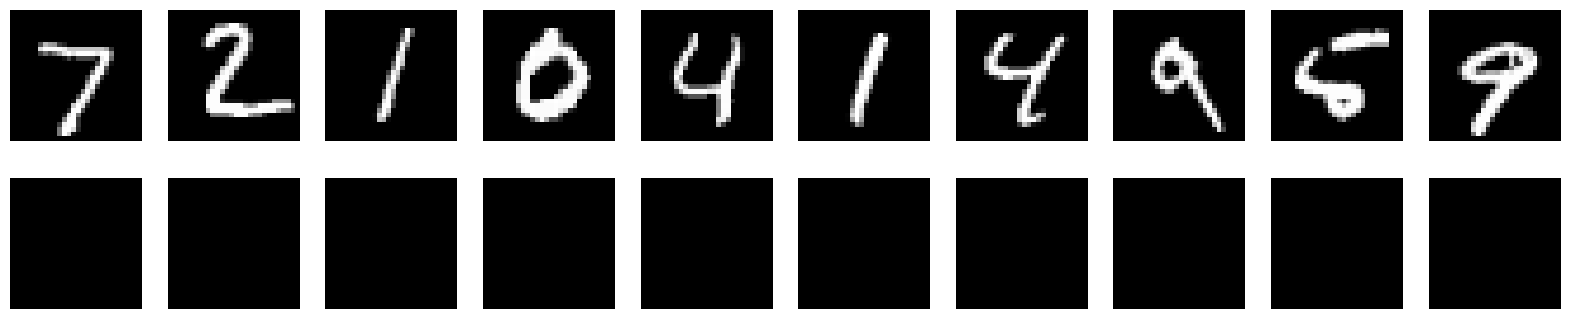

In [30]:

import matplotlib.pyplot as plt

selected_images = x_test[:10]
z_original_example = vae.encoder.predict(selected_images)[2]  # Get latent space of an image
z_rotated_predicted = mlp.predict(z_original_example)  # Get the predicted latent space of the rotated image
rotated_image_predicted = vae.decoder.predict(z_rotated_predicted)  # Decode the predicted latent space

# Visualize the results
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    axes[0, i].imshow(selected_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(rotated_image_predicted[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

plt.show()


In [34]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Use the same number of samples for both
num_samples = min(len(x_test), len(rotated_x_test))  # Take the minimum number of samples
z_original_test = vae.encoder.predict(x_test[:num_samples])[2]
z_rotated_test = vae.encoder.predict(rotated_x_test[:num_samples])[2]

# Get MLP predictions
z_rotated_predicted = mlp.predict(z_original_test)

# Calculate metrics
mse = mean_squared_error(z_rotated_test, z_rotated_predicted)
mae = mean_absolute_error(z_rotated_test, z_rotated_predicted)
r2 = r2_score(z_rotated_test, z_rotated_predicted)

# Print metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Squared Error (MSE): 2130.39306640625
Mean Absolute Error (MAE): 21.379337310791016
R-squared (R2): -0.0025686502922326326
